# Hail Conv Net Filter Activations

This notebook contains the examples that activate each convolutional filter in the last layer of a hail neural net.

In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import keras.backend as K
from keras.models import load_model
import matplotlib.pyplot as plt
import xarray as xr
from deepsky.data import load_storm_patch_data
from deepsky.gan import normalize_multivariate_data, unnormalize_multivariate_data
from scipy.ndimage import gaussian_filter
import yaml
from os.path import join, exists

Using TensorFlow backend.


In [2]:
config_file = "/users/dgagne/deepsky/config/spatial_storm_model_config.yaml"
with open(config_file) as config_obj:
    config = yaml.load(config_obj)

Load storm data from netCDF and normalize it.

In [3]:
data_path = "/users/dgagne/ncar_control_storm_patches/"
input_variables = config["input_variables"]
num_proc = 4
print("Loading data")
storm_data, storm_meta = load_storm_patch_data(data_path, input_variables, num_proc)
storm_norm_data, storm_scaling_values = normalize_multivariate_data(storm_data)

Loading data
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050500_mem_01.nc 255
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc 460
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc 640
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050600_mem_01.nc 935
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050700_mem_01.nc 850
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050800_mem_01.nc 1300
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050900_mem_01.nc 1935
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016051000_mem_01.nc 2010
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016051200_mem_01.nc 1015
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016051500_mem_01.nc 690
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016051300_mem_01.nc 1020
/us

In [4]:
ls /scratch/dgagne/spatial_storm_results_20171220/

conv_net_best_params.csv
conv_net_param_combos.csv
conv_net_param_scores_sample_000.csv
conv_net_param_scores_sample_001.csv
conv_net_param_scores_sample_002.csv
conv_net_param_scores_sample_003.csv
conv_net_param_scores_sample_004.csv
conv_net_param_scores_sample_005.csv
conv_net_param_scores_sample_006.csv
conv_net_param_scores_sample_007.csv
conv_net_param_scores_sample_008.csv
conv_net_param_scores_sample_009.csv
conv_net_param_scores_sample_010.csv
conv_net_param_scores_sample_011.csv
conv_net_param_scores_sample_012.csv
conv_net_param_scores_sample_013.csv
conv_net_param_scores_sample_014.csv
conv_net_param_scores_sample_015.csv
conv_net_param_scores_sample_016.csv
conv_net_param_scores_sample_017.csv
conv_net_param_scores_sample_018.csv
conv_net_param_scores_sample_019.csv
conv_net_param_scores_sample_020.csv
conv_net_param_scores_sample_021.csv
conv_net_param_scores_sample_022.csv
conv_net_param_scores_sample_023.csv
conv_net_param_scores_sample_024.csv
conv_net_param_scores_sa

In [4]:
model_path = "/scratch/dgagne/spatial_storm_results_20171220/"
sample = 2
hail_cnn = load_model(join(model_path, "hail_conv_net_sample_{0:03d}.h5".format(sample)))

/users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [5]:
hail_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 15)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        12032     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 64)          0         
__________

In [6]:
dense_weights = hail_cnn.layers[-2].get_weights()[0].reshape(4,4,128)

In [24]:
dense_weights.mean(axis=0).mean(axis=0).argmax()

42

(array([ 1.,  0.,  0.,  0.,  2.,  4.,  3.,  3.,  4.,  8.,  5., 15., 10.,
        19., 16., 13., 13., 15., 13., 14., 14., 13., 14., 23., 11., 21.,
        13., 15., 17., 16., 22.,  9., 10., 15., 18., 15., 17., 12., 21.,
        10.,  6., 14.,  9.,  3.,  7.,  2.,  1.,  2.,  2.,  2.]),
 array([-0.05051645, -0.04871689, -0.04691732, -0.04511776, -0.0433182 ,
        -0.04151863, -0.03971907, -0.03791951, -0.03611994, -0.03432038,
        -0.03252082, -0.03072126, -0.02892169, -0.02712213, -0.02532257,
        -0.023523  , -0.02172344, -0.01992388, -0.01812431, -0.01632475,
        -0.01452519, -0.01272563, -0.01092606, -0.0091265 , -0.00732694,
        -0.00552737, -0.00372781, -0.00192825, -0.00012868,  0.00167088,
         0.00347044,  0.00527   ,  0.00706957,  0.00886913,  0.01066869,
         0.01246826,  0.01426782,  0.01606738,  0.01786695,  0.01966651,
         0.02146607,  0.02326563,  0.0250652 ,  0.02686476,  0.02866432,
         0.03046389,  0.03226345,  0.03406301,  0.03586258,

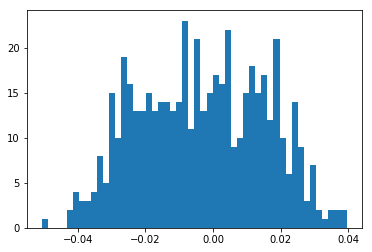

In [10]:
plt.hist(dense_weights[1:-1, 1:-1].ravel(), 50)

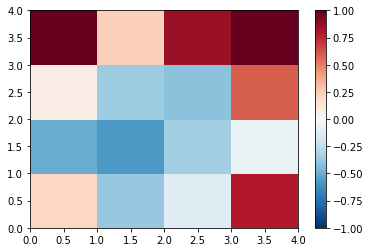

In [11]:
plt.pcolormesh(dense_weights.sum(axis=-1), vmin=-1, vmax=1, cmap="RdBu_r")
plt.colorbar()

In [15]:
np.unravel_index(12, (4,4))

(3, 0)

In [23]:
np.where(dense_weights > 0.02, 1, 0).sum(axis=-1).argmax()

12

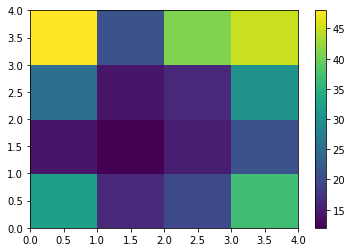

In [12]:
plt.pcolormesh(np.where(dense_weights > 0.02, 1, 0).sum(axis=-1))
plt.colorbar()

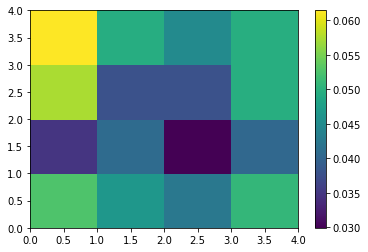

In [140]:
plt.pcolormesh(dense_weights.max(axis=-1))
plt.colorbar()

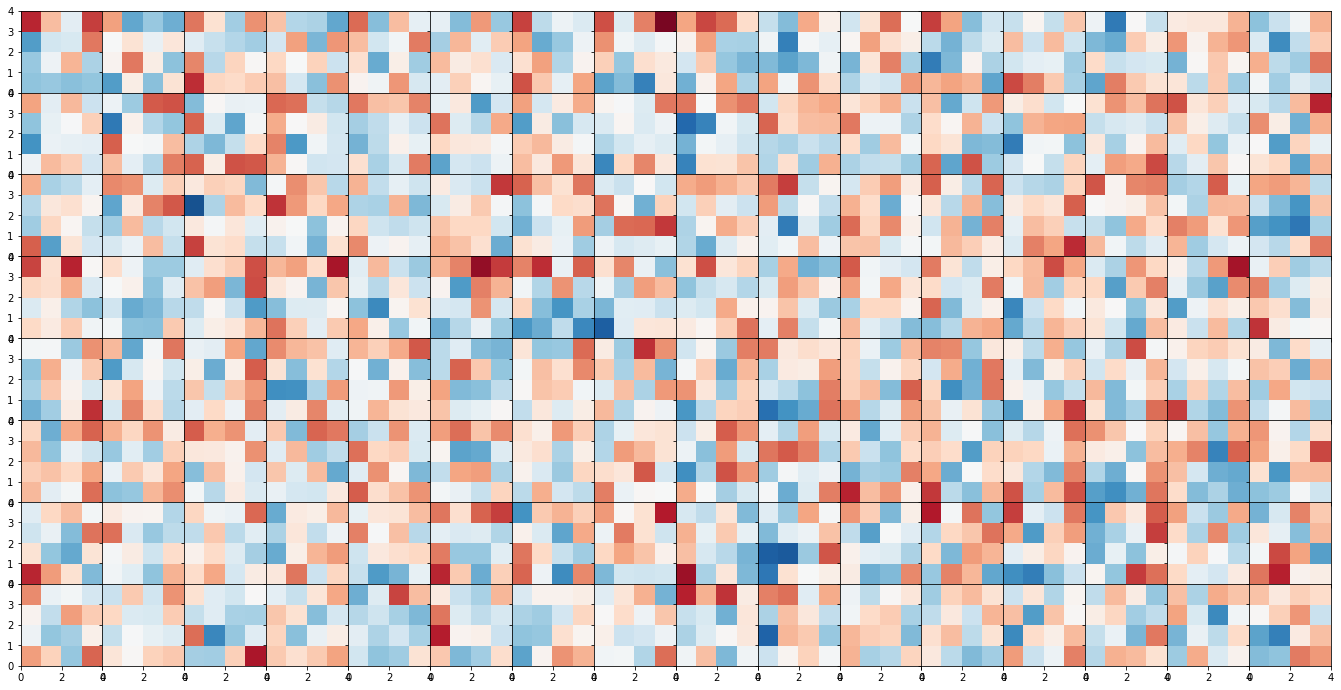

In [13]:
fig, axes = plt.subplots(8, 16, figsize=(20, 10), sharex=True, sharey=True)
plt.subplots_adjust(0.03, 0.03, 0.94, 0.94, hspace=0, wspace=0)
for a, ax in enumerate(axes.ravel()):
    ax.pcolormesh(dense_weights[:, :, a], vmin=-0.06, vmax=0.06, cmap="RdBu_r")

In [16]:
num_ex = 16
top_max_example_ids = np.zeros((dense_weights.shape[-1], num_ex), dtype=int)
top_max_acts = np.zeros((dense_weights.shape[-1], num_ex))
top_max_gradients = np.zeros((dense_weights.shape[-1], num_ex, 32, 32, 15))

for w in range(dense_weights.shape[-1]):
    print(w)
    act_func = K.function([hail_cnn.input, K.learning_phase()], 
                          [hail_cnn.layers[-6].output[:, 3, 0, w]])
    max_loss = (hail_cnn.layers[-6].output[:, 3, 0, w]- 4) ** 2
    max_grad = K.gradients(max_loss, hail_cnn.input)
    max_grad_func = K.function([hail_cnn.input, K.learning_phase()], max_grad)
    max_acts = act_func([storm_norm_data, 0])[0]
    top_max_example_ids[w] = np.argsort(max_acts)[::-1][:num_ex]
    top_max_acts[w] = max_acts[top_max_example_ids[w]]
    top_max_gradients[w] = max_grad_func([storm_norm_data[top_max_example_ids[w]]])[0]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127


In [35]:
hail_cnn.layers[-6].output[:, :, :, 4]

<tf.Tensor 'strided_slice_129:0' shape=(?, 4, 4) dtype=float32>

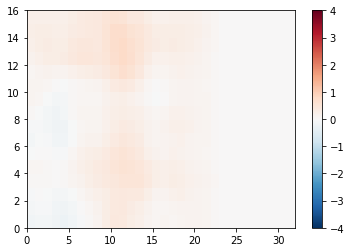

In [134]:
plt.pcolormesh(gaussian_filter(top_max_gradients[63,:, :, :, 2].mean(axis=1) / top_max_gradients[63].std(), 1), 
               vmin=-4, vmax=4, cmap="RdBu_r")
plt.colorbar()

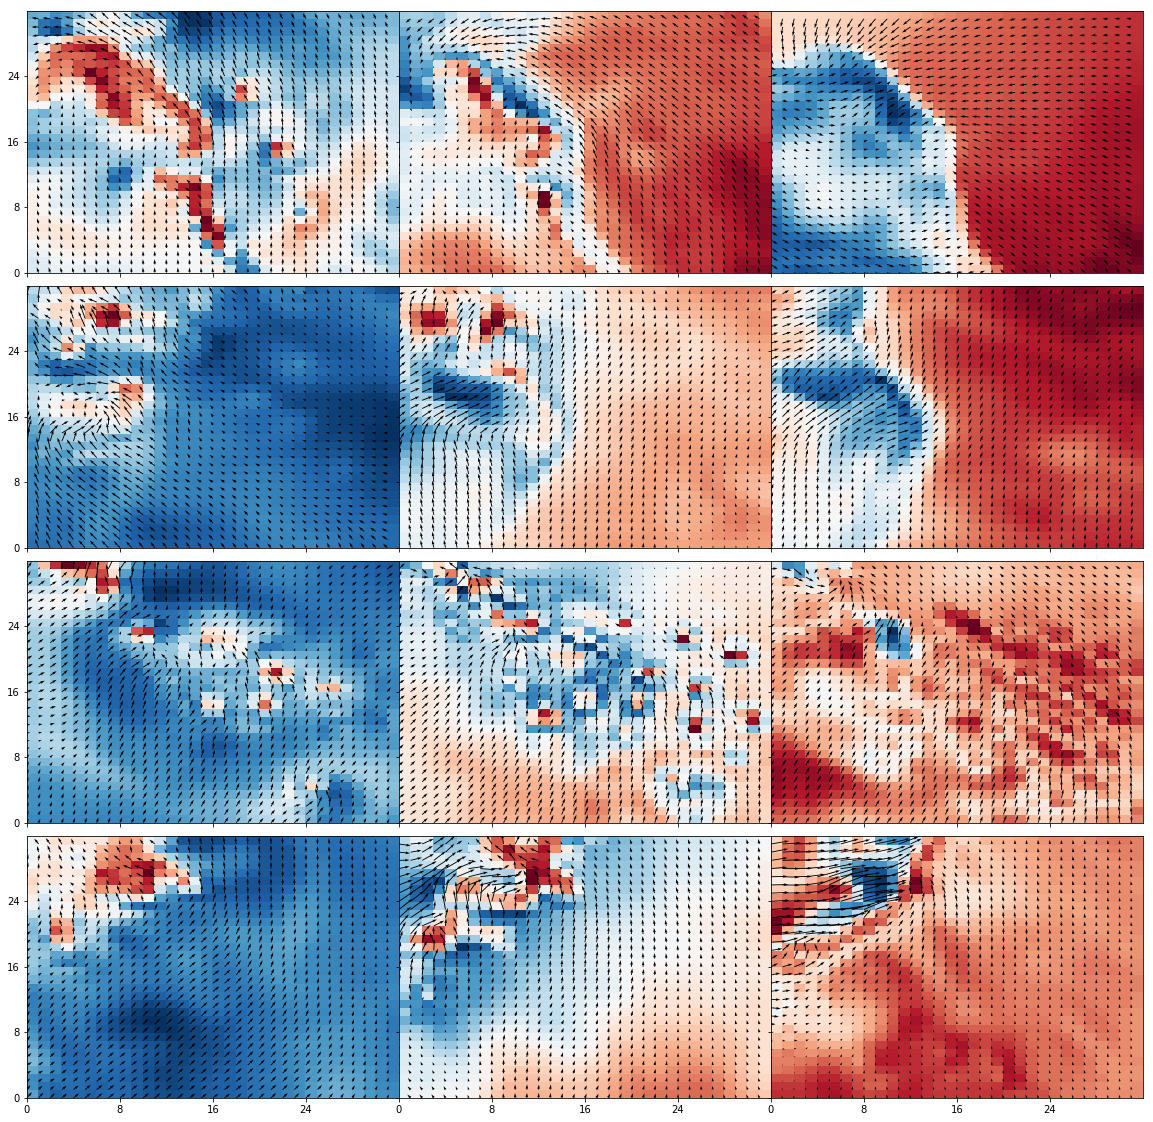

In [25]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.05)
contours = np.array([-3, -2.5, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 2.5, 3])
for w, ex_id in enumerate(top_max_example_ids[42][:4]):
    for l in range(3):
        axes[w, l].pcolormesh(storm_norm_data[ex_id, :, :, 3 + l], cmap="RdBu_r")
        #axes[w, l].contour(storm_norm_data[ex_id, :, :, 3 + l], contours, colors="red")
        #axes[w, l].contour(storm_norm_data[ex_id, :, :, 6 + l], contours, colors="green")
        axes[w, l].quiver(storm_norm_data[ex_id, :, :, 9 + l], storm_norm_data[ex_id, :, :, 12 + l])
        axes[w, l].set_yticks(np.arange(0, 32, 8))
        axes[w, l].set_xticks(np.arange(0, 32, 8))

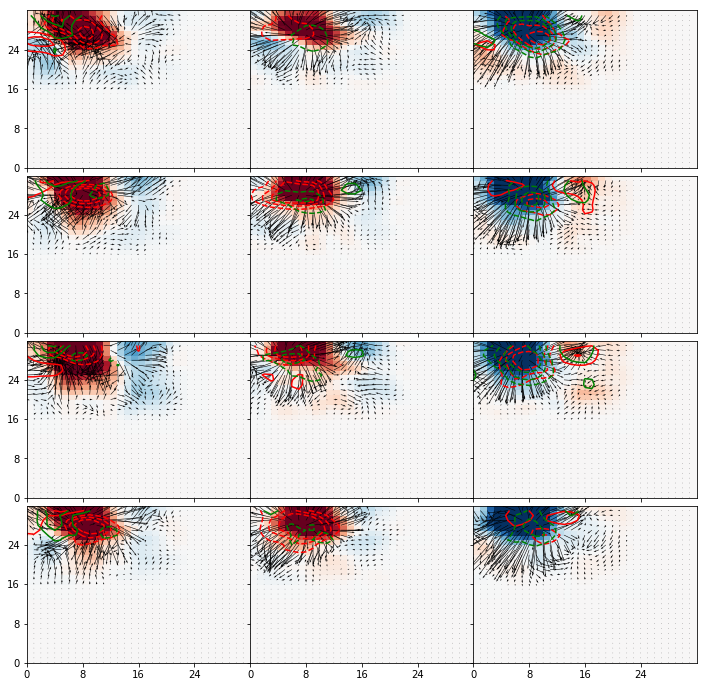

In [26]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.05)
contours = np.array([-3, -2, -1, 1, 2, 3])
c_filter = 42
for w, ex_id in enumerate(top_max_example_ids[c_filter][:4]):
    scale = top_max_gradients[c_filter, w].std()
    for l in range(3):
        axes[w, l].pcolormesh(gaussian_filter(top_max_gradients[c_filter, w, :, :, 0 + l] / scale, 1), vmin=-3, vmax=3, cmap="RdBu_r")
        axes[w, l].contour(gaussian_filter(top_max_gradients[c_filter, w, :, :, 3 + l] / scale, 1), contours, colors="red")
        axes[w, l].contour(gaussian_filter(top_max_gradients[c_filter, w, :, :, 6 + l]/ scale, 1), contours, colors="green")
        axes[w, l].quiver(gaussian_filter(top_max_gradients[c_filter, w, :, :, 9 + l] / scale, 1) , 
                          gaussian_filter(top_max_gradients[c_filter, w, :, :, 12 + l] / scale,1))
        axes[w, l].set_yticks(np.arange(0, 32, 8))
        axes[w, l].set_xticks(np.arange(0, 32, 8))

ValueError: too many values to unpack (expected 2)

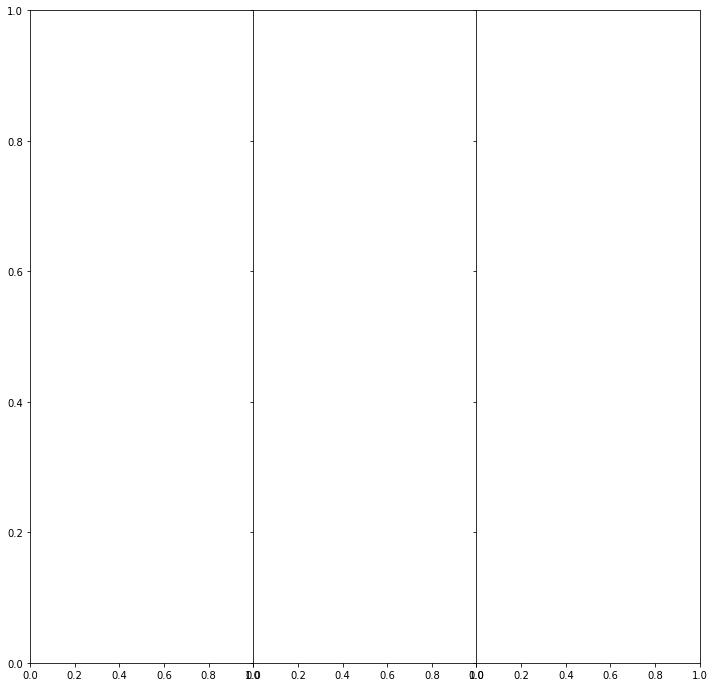

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.05)
contours = np.array([-3, -2, -1, 1, 2, 3])
c_filter = 42
scale = top_max_gradients[c_filter].std()
w = 0
for l in range(3):
    axes[l].pcolormesh(gaussian_filter(top_max_gradients[c_filter, :, :, :, 0 + l] / scale, 1), vmin=-3, vmax=3, cmap="RdBu_r")
    axes[l].contour(gaussian_filter(top_max_gradients[c_filter, :, :, :, 3 + l].mean(axis=1) / scale, 1), contours, colors="red")
    axes[l].contour(gaussian_filter(top_max_gradients[c_filter, :, :, :, 6 + l].mean(axis=1)/ scale, 1), contours, colors="green")
    axes[l].quiver(gaussian_filter(top_max_gradients[c_filter, :, :, :, 9 + l].mean(axis=1) / scale, 1) , 
                      gaussian_filter(top_max_gradients[c_filter, :, :, :, 12 + l].mean(axis=1) / scale,1))
    axes[l].set_yticks(np.arange(0, 32, 8))
    axes[l].set_xticks(np.arange(0, 32, 8))

In [146]:
dense_weights[0, 0].argmax()

90

In [86]:
top_max_example_ids[63]

array([4477, 4468, 4476, 4469,  959,  960, 4466, 5119,  930,  958, 1017,
        975,  928,  990,  961,  929])

In [138]:
top_max_gradients[0, w, :, :, 9 + l].shape

(32, 32)